In [1]:
import json
import uuid
import datetime
import time
import logging
import itertools
import re
from os import path, listdir, makedirs
from math import isnan
from statistics import mean, StatisticsError
from functools import lru_cache
from collections import Counter

import numpy as np

from nltk.corpus import stopwords
from nltk import FreqDist
import nltk

import pymorphy2


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import minmax_scale, Normalizer, StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA, NMF
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV, ParameterGrid

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

%matplotlib inline
plt.rcParams['figure.figsize']=(9,7)
plt.style.use('seaborn-deep')

In [7]:
from peewee import Model, SqliteDatabase, CharField, ForeignKeyField, CompositeKey,fn

database = SqliteDatabase("../kb/knowledge_base.db")


class BaseModel(Model):
    class Meta:
        database = SqliteDatabase("../kb/knowledge_base.db")


class Member(BaseModel):
    # Полное вербальное значение
    caption = CharField()

    # Нормализованное вербальное значение
    lem_caption = CharField()

    # Нормализованные синонимы
    lem_synonyms = CharField(null=True)

    # Формальное значение для куба
    cube_value = CharField()

    # Уровень значения измерения в иерархии измерения
    hierarchy_level = CharField(null=True)

    # Значение измерения, которое также должно быть
    # в запросе, если указано данное
    with_member = CharField(null=True)


class Measure(BaseModel):
    # Полное вербальное значение
    caption = CharField()

    # Нормализованное вербальное значение
    lem_caption = CharField()

    # Ключевые слова для меры от методологов
    key_words = CharField(null=True)

    # Ключевые слова для меры от методологов
    lem_key_words = CharField(null=True)

    # Формальное значение для куба
    cube_value = CharField()

    # Формат, в котором предоставляются данные из этой меры
    # Если 0 - то данные в рублях
    # Если 1 - то данные в процентах
    # Если 2 – то данные в штуках (сейчас кубов с такими мерами в БД нет)
    format = CharField()


class Dimension(BaseModel):
    # Название измерения
    cube_value = CharField()

    # Полное вербальное значение
    caption = CharField()

    # Ключевые слова для измерения от методологов
    key_words = CharField(null=True)

    # Нормализованные ключевые слова для измерения от методологов
    lem_key_words = CharField(null=True)

    # Значение измерения по умолчанию
    default_value = ForeignKeyField(Member, null=True)


class DimensionMember(BaseModel):
    member = ForeignKeyField(Member)
    dimension = ForeignKeyField(Dimension)

    class Meta:
        primary_key = CompositeKey('member', 'dimension')


class Cube(BaseModel):
    # Формальное название куба, например, "CLMR02"
    name = CharField()

    # Тема куба, например, "Госдолг РФ"
    caption = CharField()

    # Наиболее часто встречающиеся слова в значениях
    # измерения куба в нормализованном виде с повторениями
    auto_lem_key_words = CharField()

    # Ключевые слова, составленные методологом
    key_words = CharField(null=True)

    # Нормализованые ключевые слова от методолога
    lem_key_words = CharField(null=True)

    # Мера для куба по умолчанию
    default_measure = ForeignKeyField(Measure)


class CubeDimension(BaseModel):
    dimension = ForeignKeyField(Dimension)
    cube = ForeignKeyField(Cube)

    class Meta:
        primary_key = CompositeKey('dimension', 'cube')


class CubeMeasure(BaseModel):
    measure = ForeignKeyField(Measure)
    cube = ForeignKeyField(Cube)

    class Meta:
        primary_key = CompositeKey('measure', 'cube')

In [3]:
terr_query = Member.select(Member.lem_caption, Member.lem_synonyms).where(fn.Lower(fn.Substr(Member.cube_value, 1, 2)) == '08')

territories = []

for territory in terr_query:
    if territory.lem_caption in ["неуказанный территория", "неуказанный наименование"]:
        continue
    territories.append(set(territory.lem_caption.split()))
    if territory.lem_synonyms:
        for synonym in territory.lem_synonyms.split():
            territories.append(set([synonym]))
territories[:10]
territories.append({"кабардино", "балкария"})
territories.append({"хмао"})
territories.append({"крымский"})
territories.append({"крым"})
territories.append({"кабардино", "балкарский", "республика"})

In [4]:
@lru_cache(maxsize=16384)  # на самом деле, 8192 почти достаточно
def get_normal_form(s):
    return get_normal_form.morph.parse(s)[0].normal_form
get_normal_form.morph = pymorphy2.MorphAnalyzer()  # Лемматизатор

stop_words = set(stopwords.words("russian"))
#stop_words.remove('не')
stop_words.update(set("также иной да нет -".split()))

In [5]:
words_re = re.compile("[а-яёА-ЯЁ]+")
year_re = re.compile(r"\s(\d\d(\d\d)?)\s")
def preprocess(s: str):
    """Возвращает массив токенов по строке"""
    not_process = set(["текущийгод", "нетекущийгод", "члентерритория"])
    s = s.replace("2017", "текущийгод")
    s = s.replace("17", "текущийгод")
    s = year_re.sub(" нетекущийгод ", s + " ")
    
    res = set(map(
        lambda x: get_normal_form(x) if x not in not_process else x,
        filter(
            lambda x: x not in stop_words,
            words_re.findall(s.lower())
        )
    ))
    
    for terr in territories:
        if terr.issubset(res):
            res = res.difference(terr)
            res.add("члентерритория")
            break
            
    return tuple(res)


preprocess("хорошо жить в 2017 году 19 после 2016 ярославской области ")

('текущийгод', 'нетекущийгод', 'жить', 'члентерритория', 'год')

In [6]:
def get_test_files(test_path, prefix):
    for file_name in listdir(test_path):
        if file_name.startswith(prefix):
            yield path.join(test_path, file_name)

In [12]:
IndToClassName = {0: "Cube", 1: "Minfin"}

lines = []
for class_ind, test_path, test_prefix in [(0, '../tests/cube/', "cubes_test"), (1, '../tests/minfin/', "minfin_test")]:
    for test_path in get_test_files(test_path, test_prefix):
        with open(test_path, 'r', encoding='utf-8') as file_in:
            for idx, line in enumerate(file_in):
                line = line.strip()
                if not line:
                    continue

                if line.startswith('*'):
                    continue

                req= line.split(':')[0]
                answer = class_ind

                req = req.lower()
                req = preprocess(req)
                lines.append((req, answer))

BackClassName = {IndToClassName[i]:i for i in IndToClassName}
            
print("Всего: {} примеров".format(len(lines)))
print("Первая строка: {}".format(lines[0]))
print(json.dumps(IndToClassName,indent=4))

Всего: 2341 примеров
Первая строка: (('парижский', 'клуб', 'задолженность', 'январь', 'войти', 'текущийгод', 'страна'), 0)
{
    "0": "Cube",
    "1": "Minfin"
}


Всего 1415 слова. Из них значимых не более 805
Самые частые слова
члентерритория 587
год 441
бюджет 390
нетекущийгод 288
налоговый 268
какой 264
налог 261
доход 238
федеральный 157
бюджетный 138
консолидированный 135
поступление 130
расход 129
сколько 117
текущийгод 114
исполнение 111
финансы 106
фнс 99
государственный 99
который 97


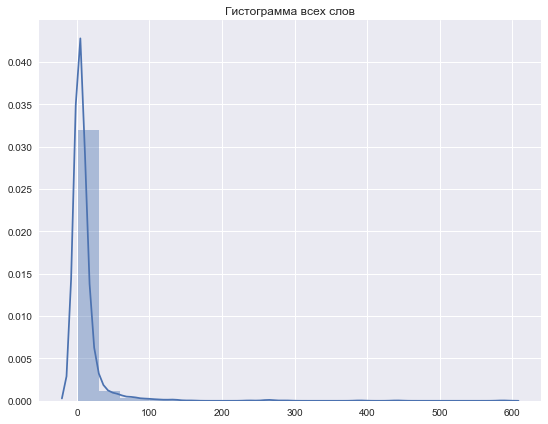

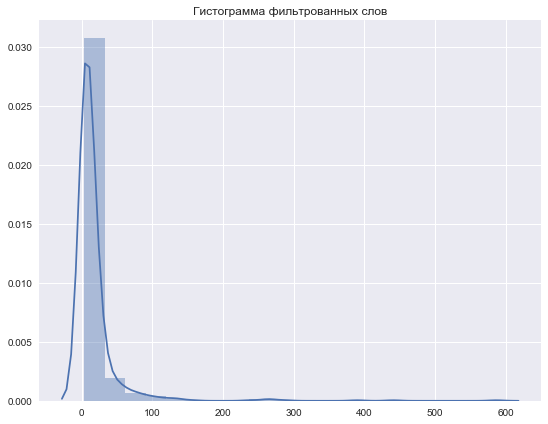

In [13]:
all_freqs = Counter()
for line in lines:
    for word in line[0]:
        all_freqs[word] += 1
print("Всего {} слова. Из них значимых не более {}".format(
    len(all_freqs),
    len(list(filter(lambda x: all_freqs[x] >= 3, all_freqs.keys())))
))
print("Самые частые слова")
for word in tuple(sorted(all_freqs.keys(), key = lambda x: all_freqs[x], reverse=True))[:20]:
    print(word, all_freqs[word])
        
sns.distplot(tuple(all_freqs.values()), bins=20)
plt.title("Гистограмма всех слов")
plt.show()

sns.distplot(tuple(filter(lambda x: x >= 3, all_freqs.values())), bins=20)
plt.title("Гистограмма фильтрованных слов")
plt.show()

In [14]:
WordIndex = {}
for ind, word in enumerate(filter(lambda x: all_freqs[x] >= 3, all_freqs.keys())):
    WordIndex[word] = ind

In [15]:
X = np.zeros((len(lines),len(WordIndex)))
Y = np.zeros(len(lines))

used_queries = set()
filtered_data = []
    
for line in lines:
    stringed_example = "".join(sorted(line[0]))
    if stringed_example in used_queries:
        continue
    used_queries.add(stringed_example)
    filtered_data.append(line)

print("Отфильтровали {} примеров".format(len(lines) - len(filtered_data)))

X = np.zeros((len(filtered_data),len(WordIndex)))
Y = np.zeros(len(filtered_data))

for ind, line in enumerate(filtered_data):
    req_words = line[0]
    for word in req_words:
        if word not in WordIndex:
            continue
        X[ind,WordIndex[word]] += 1
    Y[ind] = line[1]

print(X.shape[0])
# Нормализация среднего и среднеквадратичного отклонения
scaler = StandardScaler()
X = scaler.fit_transform(X)

Отфильтровали 532 примеров
1809


In [16]:
clf = LogisticRegression().fit(X,Y)
(clf.predict(X) == Y).sum() / Y.shape[0]

1.0

In [17]:
def getClassifier():
    classifiers = {
        "SVM": (SVC, ParameterGrid({"C":[1,4,10], "probability":[True], "decision_function_shape":["ovr"]})),
        "logistic": (LogisticRegression, ParameterGrid({"C":[1,2], "n_jobs":[-1]})),
        "GB": (GradientBoostingClassifier, ParameterGrid({
            "learning_rate":[0.3, 0.1],
            "n_estimators":[100, 240],
            "max_depth": [1,2,3]
        }))
    }
    for clf_name in classifiers:
        for params in classifiers[clf_name][1]:
            yield clf_name, params, classifiers[clf_name][0](**params)

In [19]:
KFOLD_PARTS = 15

kf = KFold(n_splits=KFOLD_PARTS,shuffle=True,random_state=42)

conf_matr = np.zeros((len(IndToClassName), len(IndToClassName)))

best_clf_name = None
best_params = None
best_log_loss = 10
best_y_test_pred = None
best_y_test_pred_proba = None
best_y_test_real = None

for clf_name, params, clf in getClassifier():
    y_train_pred = np.array([])
    y_train_real = np.array([])

    y_test_pred = np.array([])
    y_test_pred_proba = np.zeros((0,len(IndToClassName)))
    y_test_real = np.array([])
    
    for train_index, test_index in kf.split(X):
        X_train = X[train_index]
        Y_train = Y[train_index]

        X_test = X[test_index]
        Y_test = Y[test_index]

        clf.fit(X_train,Y_train)

        y_train_pred = np.concatenate((y_train_pred, clf.predict(X_train)))
        y_train_real = np.concatenate((y_train_real, Y_train))
        
        y_test_pred = np.concatenate((y_test_pred, clf.predict(X_test)))
        y_test_pred_proba = np.concatenate((y_test_pred_proba, clf.predict_proba(X_test)))
        y_test_real = np.concatenate((y_test_real, Y_test))
    
    if log_loss(y_test_real, y_test_pred_proba) < best_log_loss:
        best_clf_name = clf_name
        best_params = params
        best_log_loss = log_loss(y_test_real, y_test_pred_proba)
        best_y_test_pred = y_test_pred
        best_y_test_pred_proba = y_test_pred_proba
        best_y_test_real = y_test_real
    
    print("{} {} and train_acc: {:.3f} test_acc: {:.3f} test_log_loss {:.3f}".format(
        clf_name,
        params,
        accuracy_score(y_train_pred, y_train_real),
        accuracy_score(y_test_pred, y_test_real),
        log_loss(y_test_real, y_test_pred_proba)
    ))
print("Лучший {} {} с acc: {:.3f}".format(
    best_clf_name,
    best_params,
    best_log_loss
))

GB {'max_depth': 1, 'n_estimators': 100, 'learning_rate': 0.3} and train_acc: 0.965 test_acc: 0.947 test_log_loss 0.154
GB {'max_depth': 1, 'n_estimators': 240, 'learning_rate': 0.3} and train_acc: 0.986 test_acc: 0.966 test_log_loss 0.104
GB {'max_depth': 2, 'n_estimators': 100, 'learning_rate': 0.3} and train_acc: 0.994 test_acc: 0.968 test_log_loss 0.097
GB {'max_depth': 2, 'n_estimators': 240, 'learning_rate': 0.3} and train_acc: 0.999 test_acc: 0.973 test_log_loss 0.069
GB {'max_depth': 3, 'n_estimators': 100, 'learning_rate': 0.3} and train_acc: 0.999 test_acc: 0.967 test_log_loss 0.084
GB {'max_depth': 3, 'n_estimators': 240, 'learning_rate': 0.3} and train_acc: 1.000 test_acc: 0.975 test_log_loss 0.080
GB {'max_depth': 1, 'n_estimators': 100, 'learning_rate': 0.1} and train_acc: 0.921 test_acc: 0.911 test_log_loss 0.232
GB {'max_depth': 1, 'n_estimators': 240, 'learning_rate': 0.1} and train_acc: 0.954 test_acc: 0.939 test_log_loss 0.174
GB {'max_depth': 2, 'n_estimators': 100,

In [22]:
print(classification_report(best_y_test_real, best_y_test_pred))

             precision    recall  f1-score   support

        0.0       0.96      0.90      0.93       318
        1.0       0.98      0.99      0.98      1491

avg / total       0.97      0.97      0.97      1809

